# Overview
**Goal**: Compare snow depth derived from DEM differencing (snow-on (ASO)/snow-off (USGS 3DEP)) to the propeietary ASO Inc. snow depth product. 

Loading Data
* Snow-on ASO depth product from February 2 2020, 3m resolution
* Snow-off USGS 3DEP DEM, 1m resolution
* ASO snow-on DEM (not in SnowEx database), also from 2 Feb. 2020

Reference frames and Coregistration
* Get these into the same horizontal and vertical reference frames. How do we access the metadata for each?
* Resample each raster to the coarsest grid (ASO, 3m)
* How to align? Try the demcoreg tool? Which features do we use to co-register? Unlike glaciers we don't have the glacier inventory polygons. We do have roads in the middle of Grand Mesa to use...
    * Shashank: for glaciers, we can find features from shaded relief maps to find horizontal displacements. But for snow-on vs snow-off, maybe we can use the road (if plowed?)
    * (Coming) Shashank recipe for horizontal then vertical correction?
    * Can start with traditional dem alignment method that works on slope aspect and elevation. Nuth & Kaab (2011) or ICP, can use the PDAL and ASP implementations

Comparison with ASO Snow Depth
* compare to ASO snow depth product 
    * Resample to common grid?
    * difference our_snow_depth and aso_snow_depth

# Load the data

## Import the functions and classes we need to interact with the SnowEx database

In [91]:
# Full library imports
import os

import numpy as np
import rioxarray
import rasterio
import holoviews as hv
from shapely.geometry import Polygon, Point
from geoalchemy2.shape import to_shape, from_shape
import geoalchemy2.functions as gfunc
import pandas as pd
import geopandas as gpd


In [92]:
#%matplotlib inline
# N.B.  This notebook is a lot more interesting if initialized with 
%matplotlib widget 

In [93]:
# Import the function to get connect to the db
from snowexsql.db import get_db
# Import our class for the points, layer, image tables
from snowexsql.data import PointData, LayerData, ImageData

# import this to use define sql functions (e.g. postgis!)
from sqlalchemy.sql import func 

# Import this to convert to a rasterio object for easy plotting
from snowexsql.conversions import raster_to_rasterio 

# Import a convenient function to plot with 
from rasterio.plot import show

# This is what you will use for all of hackweek to access the db
db_name = 'snow:hackweek@52.32.183.144/snowex'

# Using the function get_db, we receive 2 ways to interact with the database
engine, session = get_db(db_name)
# session is the primary output variable that we will use to interact with the db

In [94]:
# Query the SnowEx db to determine what data is available.
# result = session.query(func.ST_AsTiff(ImageData.raster)).filter(ImageData.surveyors == 'USGS').limit(1).all()
# print(result)
# intial query is by surveyeor e.g we will be using ASO and USGS
result = session.query(ImageData.surveyors).distinct().all()
print(result)
# secondary query by product, i.e. we are looking for DEM and depth
result = session.query(ImageData.type).distinct().all()
print(result)
# Final query is time-based, so that we ensure the dates we want are available
result = session.query(ImageData.date).distinct().all()
print(result)


[('USGS',), ('UAVSAR team, JPL',), ('ASO Inc.',)]
[('swe',), ('DEM',), ('insar amplitude',), ('insar correlation',), ('depth',), ('insar interferogram real',), ('insar interferogram imaginary',)]
[(datetime.date(2020, 2, 12),), (datetime.date(2020, 2, 13),), (None,), (datetime.date(2020, 1, 31),), (datetime.date(2020, 2, 2),)]


## Since the ASO DEMs are not in the SnowEx database, we download them separately from AWS

In [95]:
#if not will only reach out to download once, if the path exists, nothing happens
if not os.path.exists("ASO_GrandMesa_dems_2020Feb1-2.zip"):
    !wget https://asopublic.s3-us-west-1.amazonaws.com/USCO/GM/2020/0201/ASO_GrandMesa_dems_2020Feb1-2.zip
        # the bang makes this a shell command, this format is unique to J notebook, and will not work in a normal python script

In [96]:
# unzip the download. Notice there are two versions of the DEM. DTM is bare earth, FSR contains veg, the difference of these two tree islands should appear with a height of about 20 m
if not os.path.exists("ASO_GrandMesa_dems_2020Feb1-2/"):
    !for f in ASO*zip ; do unzip ${f} ; done
!ls ASO_GrandMesa_dems_2020Feb1-2/

ASO_GrandMesa_Mosaic_2020Feb1-2_dtmvf_mos_3m.tif
ASO_GrandMesa_Mosaic_2020Feb1-2_fsrdemvf_mos_3m.tif
ASO_snowfree_GrandMesa_2016Sep26_dtmvf_mos_3m.tif
ASO_snowfree_GrandMesa_2016Sep26_fsrdemvf_mos_3m.tif


Question: we have DTM & DEM. What do FSR and VF mean? ??? and maybe Vegetation-Free?

We can try differencing these two to see.


In [97]:
# Load the fsr dem using rioxarray / rasterio commands. 
aso_dem_fsr_vf = rioxarray.open_rasterio("ASO_GrandMesa_dems_2020Feb1-2/ASO_GrandMesa_Mosaic_2020Feb1-2_fsrdemvf_mos_3m.tif")#fn, masked=True, default_name=name, long_name=name).squeeze(dim='band', drop=True)
aso_dem_fsr_vf

# The meta data is here, look in spatial_ref we can see the UTM system (EPSG 32612)

<xarray.DataArray (band: 1, y: 3528, x: 7576)>
[26728128 values with dtype=float32]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 7.375e+05 7.375e+05 ... 7.602e+05 7.602e+05
  * y            (y) float64 4.33e+06 4.33e+06 4.33e+06 ... 4.32e+06 4.32e+06
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    long_name:     Band 1

In [98]:
aso_dem_fsr_vf.rio.crs

CRS.from_epsg(32612)

In [99]:
# yep, change -9999's to NaN. 
# bad = aso_dem_fsr_vf.where(aso_dem_fsr_vf == -9999)
aso_dem_fsr_vf = aso_dem_fsr_vf.where(aso_dem_fsr_vf != -9999, np.nan)
print(aso_dem_fsr_vf.min())
#aso_dem_fsr_vf.plot()

<xarray.DataArray ()>
array(2684.3748, dtype=float32)
Coordinates:
    spatial_ref  int64 0


In [100]:
# Finally, reproject this data to a different CRS and save it
# https://epsg.io/26912
aso_dem_fsr_vf_reproject = aso_dem_fsr_vf.rio.reproject("EPSG:26912")
aso_dem_fsr_vf_reproject

<xarray.DataArray (band: 1, y: 3528, x: 7576)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * x            (x) float64 7.375e+05 7.375e+05 ... 7.602e+05 7.602e+05
  * y            (y) float64 4.33e+06 4.33e+06 4.33e+06 ... 4.32e+06 4.32e+06
  * band         (band) int64 1
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    long_name:     Band 1
    _FillValue:    -9999.0

In [101]:
# Use rioxarray /rasterio to open the DTM file
aso_dem_dtm_vf = rioxarray.open_rasterio("ASO_GrandMesa_dems_2020Feb1-2/ASO_GrandMesa_Mosaic_2020Feb1-2_dtmvf_mos_3m.tif")
aso_dem_dtm_vf = aso_dem_dtm_vf.where(aso_dem_dtm_vf != -9999, np.nan)
print(aso_dem_dtm_vf.min())
#aso_dem_dtm_vf.plot()

<xarray.DataArray ()>
array(2684.06, dtype=float32)
Coordinates:
    spatial_ref  int64 0


In [102]:
aso_dem_dtm_vf.rio.crs

CRS.from_epsg(32612)

In [103]:
# Finally, reproject this data to a different CRS and save it
# https://epsg.io/26912
aso_dem_dtm_vf_reproject = aso_dem_dtm_vf.rio.reproject("EPSG:26912")
aso_dem_dtm_vf_reproject

<xarray.DataArray (band: 1, y: 3528, x: 7576)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * x            (x) float64 7.375e+05 7.375e+05 ... 7.602e+05 7.602e+05
  * y            (y) float64 4.33e+06 4.33e+06 4.33e+06 ... 4.32e+06 4.32e+06
  * band         (band) int64 1
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    long_name:     Band 1
    _FillValue:    -9999.0

In [104]:
# make sure grids are the same and difference
aso_dem_fsr_vf_R = aso_dem_fsr_vf.rio.reproject_match(aso_dem_dtm_vf)
diff_map = aso_dem_fsr_vf_R - aso_dem_dtm_vf
print(type(diff_map))


<class 'xarray.core.dataarray.DataArray'>


In [105]:
# xarray is also integrated into holoviz plotting tools
# which are great for interactive data exploration in a browser
import hvplot.xarray
latitude = 39.3
diff_map.hvplot.image(x='x', y='y', rasterize=True, cmap='bwr', clim=(-40,40), aspect=1/np.cos(np.deg2rad(latitude)))

:DynamicMap   [band]
   :Image   [x,y]   (value)

The difference in the products seems to be related to trees on the mesa

## ASO Snow Depth product from SnowEx database

In [106]:
bbox = diff_map.rio.bounds()
x1 = bbox[0] 
x1

737454.0

In [107]:
# set up to gather rasters
# Date for ASO flight
dt = pd.to_datetime('02-02-2020').date()

#flat spot, with measurements
p = Point(743076, 4322689)

# Build a polygon  using corner coords
bbox = diff_map.rio.bounds()
x1 = bbox[0] 
y1 = bbox[1]
x2 = bbox[2] 
y2 = bbox[3]

# Make two versions. 1 for working directly with the DB and one for plotting
bbox_shp = Polygon([[x1, y1], [x1, y2], [x2, y2], [x2, y1]])       # Construct it using shapely
db_bbox = from_shape(bbox_shp, srid=26912).ST_AsEWKT()        # Save one for use with the database

db_bboxt_df = gpd.GeoDataFrame({'geometry':[bbox_shp, p]})     # Save one for plotting

#largest resolution used
resolutions = session.query(ImageData.surveyors, func.ST_PixelWidth(ImageData.raster)).filter(ImageData.type=='depth').distinct().all()
res = max([r[1] for r in resolutions])
res = (res,res)
print('Using a resolution of {} m'.format(res[0]))

Using a resolution of 3.000000000007304 m


# Next cell is a function definition

In [108]:
# Micah's code snippet below
# Define a function to retrieve a resampled and clip dataset
def retrieve_matched_raster(data_name, surveyors, polygon, res, date=None):
    '''
    Gather all rasters filted by name and surveyors that intersect the polygon. Resample to the resolution provided
    and clip to the polygon
    '''

    # Retrieve the original resolution
    q =  session.query(func.ST_PixelWidth(ImageData.raster), func.ST_PixelHeight(ImageData.raster))
    res_o = q.filter(ImageData.type == data_name).filter(ImageData.surveyors == surveyors).limit(1).all()
    print('Original Resolution = {} x{}'.format(res_o[0][0], res_o[0][1]))

    # Return a tiff thats resampled the snow off to the same resolution as the Snow on and clip to the same extents
    s = func.ST_Clip(func.ST_Rescale(gfunc.ST_Union(ImageData.raster, type_=Raster), res[0], -1 * res[1],  'Bilinear'), polygon, True)

    # Filter by surveyors and data name DEM
    q = session.query(func.ST_AsTiff(s)).filter(ImageData.type == data_name)
    q = q.filter(ImageData.surveyors == surveyors)

    # Grab all tile that intersect the snow on boundary
    q = q.filter(gfunc.ST_Intersects(ImageData.raster, polygon))

    # Filter on a date if provided
    if date != None:
        q.filter(ImageData.date == date)

    records = q.all()

    # Convert to Rasterio
    dataset = raster_to_rasterio(session, records)[0]
    print('Raster {} X {}, Final Res = {} x {}'.format(dataset.width, dataset.height, dataset.res[0], dataset.res[1]))
    print(dataset.bounds)
    return dataset

# Define a convenient function to print out stats
def print_stats(img):
    for stat in ['mean','min','max','std']:
        fn = getattr(np, 'nan' + stat)
        print('\t{} = {}'.format(stat, fn(img)))

# Gather Rasters

In [109]:
data_name = 'depth'
q =  session.query(func.ST_PixelWidth(ImageData.raster), func.ST_PixelHeight(ImageData.raster))
res_o = q.filter(ImageData.type == 'depth').filter(ImageData.surveyors == 'ASO Inc.').limit(1).all()
print('Original Resolution = {} x{}'.format(res_o[0][0], res_o[0][1]))

Original Resolution = 3.000000000007304 x3.000000000007304


In [115]:
 s = func.ST_Clip(func.ST_Rescale(gfunc.ST_Union(ImageData.raster), res[0], -1 * res[1],  'Bilinear'), db_bboxt_df, True)
 # Filter by surveyors and data name DEM
 q = session.query(func.ST_AsTiff(s)).filter(ImageData.type == data_name)
 q = q.filter(ImageData.surveyors == 'ASO Inc.')
 
 q = q.filter(gfunc.ST_Intersects(ImageData.raster, db_bboxt_df))
 q.all()

ProgrammingError: (psycopg2.ProgrammingError) can't adapt type 'GeoDataFrame'
[SQL: SELECT ST_AsTIFF(ST_Clip(ST_Rescale(ST_Union(public.images.raster), %(ST_Rescale_1)s, %(ST_Rescale_2)s, %(ST_Rescale_3)s), %(ST_Clip_1)s, %(ST_Clip_2)s)) AS "ST_AsTIFF_1" 
FROM public.images 
WHERE public.images.type = %(type_1)s AND public.images.surveyors = %(surveyors_1)s AND ST_Intersects(public.images.raster, %(ST_Intersects_1)s)]
[parameters: {'ST_Rescale_1': 3.000000000007304, 'ST_Rescale_2': -3.000000000007304, 'ST_Rescale_3': 'Bilinear', 'ST_Clip_1':                                             geometry
0  POLYGON ((737454.000 4319634.000, 737454.000 4...
1                     POINT (743076.000 4322689.000), 'ST_Clip_2': True, 'type_1': 'depth', 'surveyors_1': 'ASO Inc.', 'ST_Intersects_1':                                             geometry
0  POLYGON ((737454.000 4319634.000, 737454.000 4...
1                     POINT (743076.000 4322689.000)}]
(Background on this error at: http://sqlalche.me/e/13/f405)

In [112]:
# Dictionary to hold rasterio datsets
rio = {}

# Dictionary to hold the numpy arrays
imgs = {}

# No Data as prescribed by metadata
nodata = {'QSI':-3.4028234663852886e+38, 'USGS': -999999, 'ASO':-9999}

for surveyor in ['QSI', 'ASO', 'USGS']:
    print('\n{}:'.format(surveyor))
    args = ['DEM', surveyor, db_bbox, res]
    kwargs = {}

    if surveyor == 'QSI':
        kwargs['date'] = dt

    rio[surveyor] = retrieve_matched_raster(*args, **kwargs)
    img = rio[surveyor].read(1)
    if surveyor in nodata.keys():
        ind = img <= nodata[surveyor]
        img[ind] = np.nan
        ind = img == np.inf
        img[ind] = np.nan
    imgs[surveyor] = img


QSI:


IndexError: list index out of range

In [20]:
query = session.query(ImageData.date)
query = query.filter(ImageData.surveyors == "ASO Inc.")
query = query.filter(ImageData.type == "depth")
query = query.distinct()
result = query.all()
print(result)

[(datetime.date(2020, 2, 2),), (datetime.date(2020, 2, 13),)]


We can see that the ASO snow **depth** products (not to be confused with the DEMs) are from 2020-02-02 and 2020-02-13. We'll stick to 2020-02-02 for this analysis.

In [49]:
# Retrieve some of the ASO Snow Depth tiles
query = session.query(func.ST_AsTiff(ImageData.raster))
query = query.filter(ImageData.surveyors == "ASO Inc.")
query = query.filter(ImageData.type == "depth")
query = query.filter(ImageData.date == "2020-02-02")
result = query.count()
print(result)

128


It appears that we have 128 different ASO depth tiles to work with. Can we plot the tiles on the map?

[(<memory at 0x7f30e8571700>,), (<memory at 0x7f30e8571040>,), (<memory at 0x7f30e8571940>,), (<memory at 0x7f308512d040>,), (<memory at 0x7f308512d100>,)]
datasets:  <class 'list'>
datasets[2]: <open DatasetReader name='/vsimem/09f3a89d-6803-4c32-bf0a-7cce4ac0071e/09f3a89d-6803-4c32-bf0a-7cce4ac0071e.tif' mode='r'> <class 'rasterio.io.DatasetReader'>
<class 'numpy.ndarray'>
(500, 500)


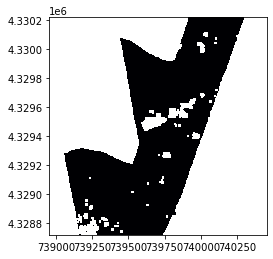

<AxesSubplot:>

In [50]:
# Retrieve some of the ASO Snow Depth tiles
query = session.query(func.ST_AsTiff(ImageData.raster))
query = query.filter(ImageData.surveyors == "ASO Inc.")
query = query.filter(ImageData.type == "depth")
query = query.filter(ImageData.date == "2020-02-02")
query = query.limit(5)
result = query.all()
print(result)
datasets = raster_to_rasterio(session, result)
print('datasets: ', type(datasets))
print('datasets[2]:', datasets[2], type(datasets[0]))


array = datasets[2].read(1) # Read the only band from our DEM into a numpy array, which would lose the coordinate system
print(type(array))
print(array.shape)

# Plot the georeferenced image 
show(datasets[2], cmap='magma')

## Get the USGS 3DEP product from the database and read it in as a rioxarray array for later use
Note: rioxarray can't read the `rasterio.io.DatasetReader` directly, instead it tries to open the .tif file which is not on our machine. Workaround: save the TIFF as a local file and point rioxarray to that.

In [46]:
result = session.query(func.ST_AsTiff(ImageData.raster)).filter(ImageData.surveyors == 'USGS').count()
print("Number of 3DEP tiles:", result)

Number of 3DEP tiles: 1713


Can we merge these tiles into a single VRT? Need to use gdalbuildvrt? https://github.com/snowex-hackweek/website/blob/main/book/tutorials/geospatial/geospatial_cookbook_rendered.ipynb

datasets:  <class 'list'>
raster: <open DatasetReader name='/vsimem/8da3cefb-ecbf-475d-aeae-2b7489fd425d/8da3cefb-ecbf-475d-aeae-2b7489fd425d.tif' mode='r'> <class 'rasterio.io.DatasetReader'>
<class 'numpy.ndarray'>
(500, 500)


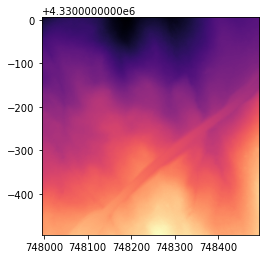

/vsimem/8da3cefb-ecbf-475d-aeae-2b7489fd425d/8da3cefb-ecbf-475d-aeae-2b7489fd425d.tif ???


<xarray.DataArray (band: 1, y: 500, x: 500)>
[250000 values with dtype=float32]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 7.48e+05 7.48e+05 7.48e+05 ... 7.485e+05 7.485e+05
  * y            (y) float64 4.33e+06 4.33e+06 4.33e+06 ... 4.33e+06 4.33e+06
    spatial_ref  int64 0
Attributes:
    _FillValue:    -3.4028234663852886e+38
    scale_factor:  1.0
    add_offset:    0.0

In [43]:
# Remember in the query parentheses is what we get back, in this case were asking for the raster data as a geotiff

result = session.query(func.ST_AsTiff(ImageData.raster)).filter(ImageData.surveyors == 'USGS').limit(1).all()

# Now make it more available as a python object 
datasets = raster_to_rasterio(session, result)
raster = datasets[0]
raster_id = "???" # not sure how to retrieve the other tile metadata?
print('datasets: ', type(datasets))
print('raster:', raster, type(raster))

array = raster.read(1) # Read the only band from our DEM into a numpy array, which would lose the coordinate system
print(type(array))
print(array.shape)

# Plot the georeferenced image 

show(raster, cmap='magma')
print(raster.name, raster_id)

# Write our raster to disk
# Copy the profile/tiff metadata (not to be confused with the database metadata)
profile = raster.profile
filename = f"raster{raster_id}.tif"
with rasterio.open(filename, 'w', **profile) as dst:
    dst.write(raster.read(1), 1)

# Reopen with rioxarray
da = rioxarray.open_rasterio(filename)
da

# Common reference frame + coregistration

## Check the metadata for each of our rasters

# Analysis

In [ ]:
# Close out the session to avoid hanging transactions
session.close()